In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import numpy as np
from torch import nn
import torch
import torch.nn.functional as F
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

    
class XceptionBlock(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super().__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x
        
class SamplingBlock(nn.Module):
    def __init__(self, n_channels, n_categories, depth):
        super().__init__()
        self.n_categories = n_categories
        self.n_channels = n_channels
        self.xception_block1 = XceptionBlock(
            n_categories * n_channels, n_categories * n_channels, reps=depth)
        self.upsampler = nn.UpsamplingNearest2d(scale_factor=2)
        self.xception_block2 = XceptionBlock(
            2 * n_categories * n_channels, n_categories * n_channels, reps=depth)
    
    def forward(self, image, previous_output=None, with_sigmoid=True):
        assert image.size()[1] == self.n_channels, \
            f'Provided image channels({image.size(1)}) do not match with the ones given in the model definition({self.n_channels})'
        image = image.repeat((1, self.n_categories, 1, 1))
        if previous_output is None:
            x = self.xception_block1(image)
            
        else:
            previous_output = self.upsampler(previous_output)
            x = self.xception_block2(torch.cat((image, previous_output), dim=1))
        if with_sigmoid:
            return torch.sigmoid(x)
        return x

class SamplingSegmentation(nn.Module):
    def __init__(self, n_channels, n_categories, depth):
        super().__init__()
        self.n_categories = n_categories
        self.n_channels = n_channels
        self.depth = depth + 1
        self.blocks = nn.ModuleList([SamplingBlock(n_channels, n_categories, d + 1) for d in reversed(range(self.depth))])
        self.final_layer = XceptionBlock(
            self.depth * n_categories * n_channels, n_categories, reps=self.depth)
        self.upsamplers = nn.ModuleList([nn.UpsamplingNearest2d(scale_factor=2**d) for d in reversed(range(self.depth))])
    
    def forward(self, image, use_sigmoid=True):
        outputs = []
        inputs = [image]
        assert image.size()[1] == self.n_channels, \
            f'Provided image channels({image.size(1)}) do not match with the ones given in the model definition({self.n_channels})'
        assert image.size()[2] % 2**(self.depth - 1) == 0 and image.size()[3] % 2**(self.depth - 1) == 0,\
            f'Image H and W must be divisible by {2**self.depth}, but the following size was provided: {image.size()}'
        for block in self.blocks[:-1]:
            inputs.append(F.interpolate(inputs[-1], scale_factor=0.5, mode='bilinear', align_corners=False))
        x = None
        for cnt, (inp, block, upsampler) in enumerate(zip(inputs[::-1], self.blocks, self.upsamplers)):
            x = block(inp, x)
            outputs.append(upsampler(x))
        output = self.final_layer(torch.cat(outputs, dim=1))
        if use_sigmoid:
            output = torch.sigmoid(output)
        return output

In [7]:
model = SamplingSegmentation(3, 1, 6).cuda()
out = model(torch.ones((5, 3, 64, 64)).cuda())

/home/vaslem/Code/kaggle/.venv/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


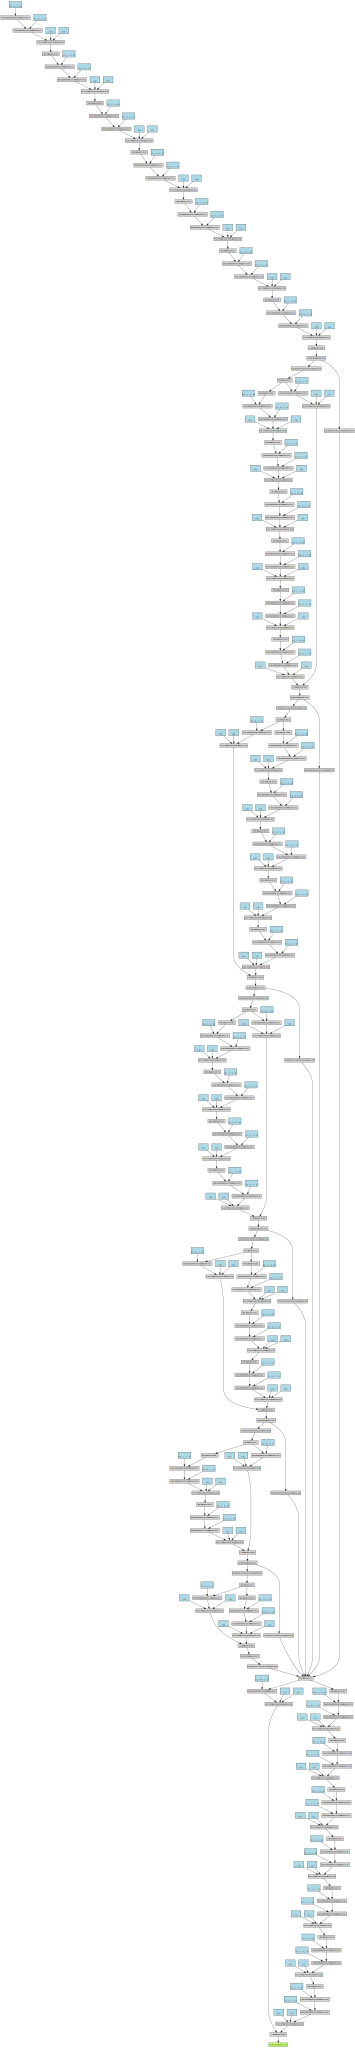

In [5]:
from torchviz import make_dot
make_dot(out, params=None)

In [8]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

3079

In [ ]:
class SamplingSegmentation(nn.Module):
    def __init__(self, scales):
        super().__init__()
        